# Fundamenal modes of vibration of a simple building

Find the fundamental modes of vibration of a three-storey building with four columns of stiffness $EI$ and height $h$, where each storey has mass $m$.

The equilibrium equation of a multiple degree of freedom system is written in matrix matrix form,
$$
\mathbf{M}\ddot{\mathbf{u}} + \mathbf{K}\mathbf{u} = \mathbf{0} \ , \quad
\mathbf{M} = \left[\begin{matrix}
m_1 & 0 & 0 \\
0 & m_2 & 0 \\
0 & 0 & m_3
\end{matrix}\right] \ , \quad
\mathbf{K} = \left[\begin{matrix}
k_1 + k_2 & -k_2 & 0 \\
-k_2 & k_2 + k_3 & -k_3 \\
0 & -k_3 & k_2 + k_3
\end{matrix}\right]
$$

Which trying test solutions $\mathbf{u} = \mathbf{v}\sin(\omega t + \varphi)$ leads to a generalized eigenvalue problem of the type:

$$
\det(\mathbf{K} - \omega^2 \mathbf{M}) = 0
$$

| Geometry of the building |  |
|--------------------------|--|
| Number of stories | 3 |
| Columns | HEB 200 ($\times 4$) |
| Young modulus | $2.7GPa$ |
| Storey height | $0.3m$ |
| Storey mass | $400g$ |

## Assembly of the matrices

First of all, the mass and stiffness matrices are built according to the given data.

In [43]:
import numpy as np

# Problem parameters
n_stories = 3                            # Number of storeys
m = 350 * np.ones(n_stories) / 1000      # Mass per storey in kg (converted from g to kg)
E = 2.7e9                                # Young's modulus in Pa (N/m²)
d = 0.006                                # Diameter of nylon column in meters (M6 screw)
I = np.pi * d**4 / 64                    # Moment of inertia for a circular cross-section in m^4
h = 0.3                                  # Height of each storey in meters
k = 4 * 12 * E * I / h**3                # Stiffness of 4 nylon columns per storey in N/m

# Initialize mass and stiffness matrices
M = np.zeros((n_stories, n_stories))
K = np.zeros((n_stories, n_stories))

# Fill mass and stiffness matrices
M[0, 0] = m[0]
K[0, 0] = k
for i in range(1, n_stories):
    M[i, i] += m[i]
    K[i, i] += k
    K[i - 1, i - 1] += k
    K[i, i - 1] += -k
    K[i - 1, i] += -k

# Print the resulting mass and stiffness matrices
print("Mass Matrix (M):\n", M)
print("\nStiffness Matrix (K):\n", K)


Mass Matrix (M):
 [[0.35 0.   0.  ]
 [0.   0.35 0.  ]
 [0.   0.   0.35]]

Stiffness Matrix (K):
 [[ 610.72561186 -305.36280593    0.        ]
 [-305.36280593  610.72561186 -305.36280593]
 [   0.         -305.36280593  305.36280593]]


## Solution of the eigenvalue problem

We eill use the already implemented function in `scipy` library. More options can be used when calling the library, such as computing only the desired evgenvalues passing the optional argument `eigvals=(0,n)`.

In [44]:
from scipy.linalg import eigh
eigvals, eigvecs = eigh(K, M)

Normalization of the eigenvectors and computation of the frequencies. Note that the matrix of eigenvectors needs to be transposed.

In [45]:
eigvecs_n = [v/np.sqrt(v@M@v) for v in eigvecs.T] # normalization
eigvecs_n = np.array(eigvecs_n)                   # cast into numpy array
frequencies = eigvals**0.5
periods = 2*np.pi/frequencies
print("frequiencies F =\n",frequencies)
print("periods P =\n",periods)

frequiencies F =
 [13.14543362 36.83268651 53.22477411]
periods P =
 [0.47797475 0.17058721 0.11805001]


### Modal analysis

For each mode of deformation, the *modal mass* is defined as
$$
m_i = \frac{\mathbf{v}_i^T \mathbf{M} \mathbf{v}_i}{\mathbf{v}_i^T\mathbf{v}_i}
$$

Another important concept is the *partcipative* or *effective mass*. It is defined considering the structure under a general earthquake defined by a direction $\mathbf{d}$. The unid vector $\mathbf{d}$ is applied as unit displacement for all the nodes. Thus, this yields the definition of the *effective mass*
$$
M_i = \frac{(\mathbf{v}_i^T \mathbf{M} \mathbf{d})^2}{\mathbf{v}_i^T \mathbf{M} \mathbf{v}_i}
$$

It verifies that the sum of the modal or the effective masses are equal to the total mass of the building:
$$
\sum_i m_i = \sum_i M_i = M = \text{trace}(\mathbf{M})
$$


In [54]:
d = np.ones(n_stories)
modal_mass = [(v@M@v) / (v@v) for v in eigvecs_n] # eigvecs.T
participation = [(v@M@d) / (v@M@v) for v in eigvecs_n] # eigvecs.T
eff_mass = [(v@M@d)**2 / (v@M@v) for v in eigvecs_n] # eigvecs.T
traci = np.trace(eigvals)
eff_mass_rel = eff_mass / traci
print("tace Matrix M\n",traci)
print("Effective mass  =\n",eff_mass)
print("Mass trace =\n",eff_mass_rel)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 5 is different from 3)

## Graphical representation of the solution

For graphical purpose, an extra node with null displacement has been added to the deformations vector. This node corresponds to the base level.

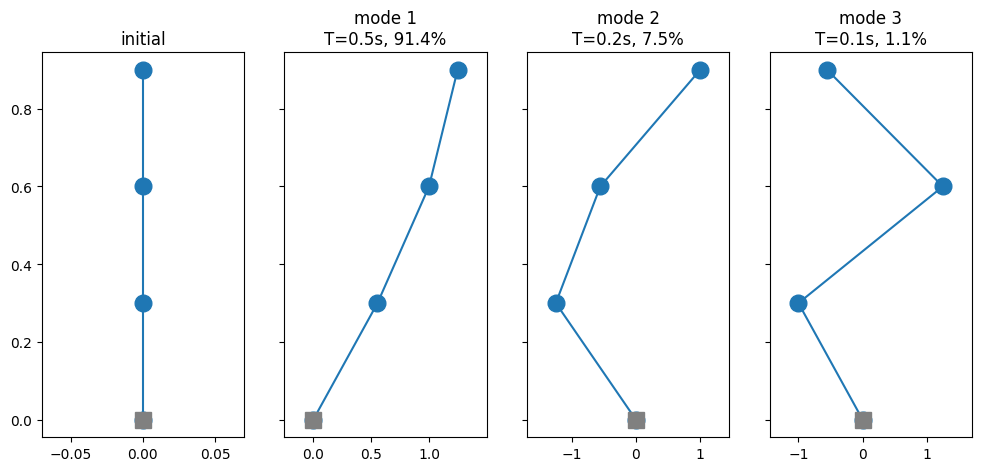

In [36]:
import matplotlib.pyplot as plt

z = np.arange(0, n_stories+1)*h  # vertical position of the stories. There is an extra position for the base level
fig, ax = plt.subplots(1,n_stories+1, sharey=True, figsize=(12,5))

def plot_mode(v,i,title):
  ax[i].plot(v,z, marker='o', markersize=12)
  ax[i].plot(0,0, marker='s', markersize=12, markeredgecolor='gray', markerfacecolor='gray')
  ax[i].set_title(title)
  ax[i].margins(x=.2)

plot_mode(np.zeros(n_stories+1),0,'initial')

n_modes = n_stories
for i in range(n_modes):
  vi = eigvecs_n[i]
  vi = np.insert(vi,0,0)    # we add a zero displacement at the base level
  legend = f'mode {i+1}\nT={periods[i]:.1f}s, {eff_mass_rel[i]:.1%}'
  plot_mode(vi,i+1,legend)

plt.show()